# Day 13 — Dimensionality Reduction Techniques

**Focus:** PCA, t-SNE, and UMAP — theory, implementation, visualization, and benchmarking.

This notebook uses the **`sklearn` Digits dataset** (compact and excellent for visualization).  



**What you'll find:**  
- Explanations of PCA, t-SNE, UMAP  
- Working code (scikit-learn and umap-learn)  
- Visualizations of embeddings (2D / 3D)  
- Comparison of explained variance and classifier performance (before / after)


In [1]:
# If running in Colab, uncomment the following to install umap-learn
# !pip install --quiet umap-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported. NumPy version:", np.__version__)


Libraries imported. NumPy version: 2.0.2


## 1) Dataset

We use `sklearn.datasets.load_digits()` — 1797 samples, 64 features (8x8 images).  
This is compact and quick for PCA, t-SNE, and UMAP demonstrations.


In [2]:
# Load digits dataset
digits = datasets.load_digits()
X = digits.data
y = digits.target
feature_names = [f'pixel_{i}' for i in range(X.shape[1])]
print("X shape:", X.shape)
print("Number of classes:", len(np.unique(y)))


X shape: (1797, 64)
Number of classes: 10


## 2) Preprocessing

Standardize features before applying PCA / t-SNE / UMAP. Standardization centers features and scales to unit variance which is important for PCA and often beneficial for t-SNE/UMAP.


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Mean (first 5 features):", X_scaled.mean(axis=0)[:5])
print("Std (first 5 features):", X_scaled.std(axis=0)[:5])


Mean (first 5 features): [ 0.00000000e+00 -2.56086502e-16 -2.34771702e-16 -3.05326777e-16
  1.39689163e-16]
Std (first 5 features): [0. 1. 1. 1. 1.]


## 3) Principal Component Analysis (PCA)

PCA finds orthogonal directions (principal components) that capture the largest variance in the data.  
We can inspect explained variance ratio to choose the number of components. PCA is linear and fast.


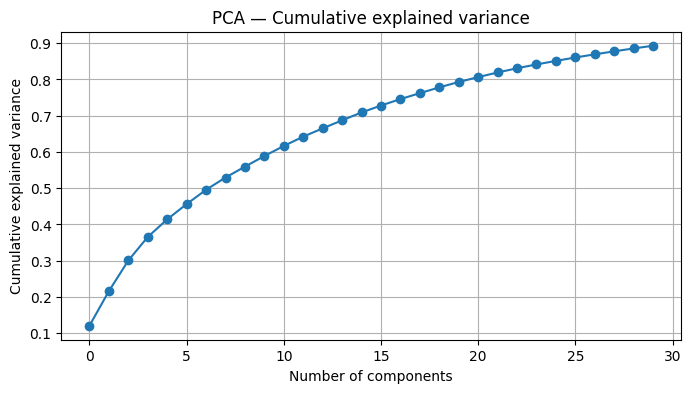

Shape after PCA (2D): (1797, 2)


In [4]:
# Fit PCA and plot explained variance
pca = PCA(n_components=30, random_state=42)
pca.fit(X_scaled)
explained_ratio = pca.explained_variance_ratio_

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(explained_ratio), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA — Cumulative explained variance')
plt.grid(True)
plt.show()

# Choose 2 components for visualization
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)
print("Shape after PCA (2D):", X_pca2.shape)


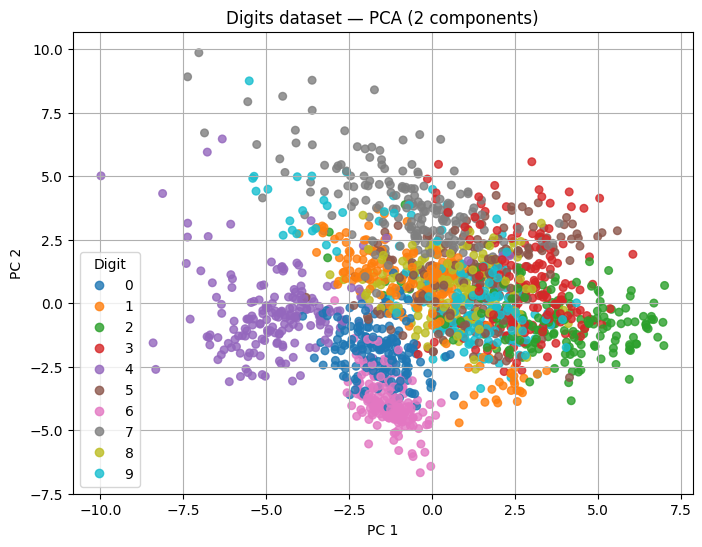

In [5]:
# Scatter plot of the 2D PCA projection
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, cmap='tab10', s=30, alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Digit")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Digits dataset — PCA (2 components)')
plt.grid(True)
plt.show()


## 4) t-SNE (t-distributed Stochastic Neighbor Embedding)

 T-SNE is a non-linear technique optimized for visualizing local structure (neighborhoods) in 2D/3D. It preserves local similarities but not global structure.  



In [6]:
# Run t-SNE for 2D embedding (can be slow)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, init='pca')
X_tsne2 = tsne.fit_transform(X_scaled)
print("t-SNE 2D shape:", X_tsne2.shape)


t-SNE 2D shape: (1797, 2)


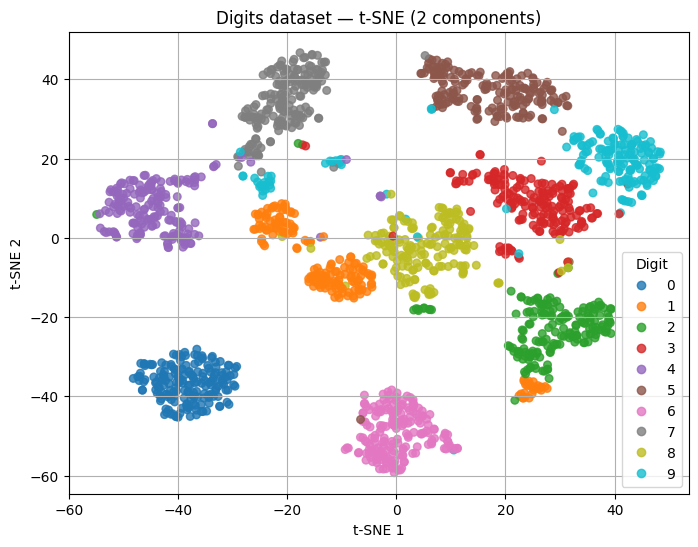

In [7]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=y, cmap='tab10', s=30, alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Digit")
plt.title('Digits dataset — t-SNE (2 components)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()


## 5) UMAP (Uniform Manifold Approximation and Projection)

UMAP is a graph-based manifold learning technique. It's often faster than t-SNE, scales well to larger data, and preserves more global structure.  



In [8]:
# UMAP: optional install line for Colab:
# !pip install --quiet umap-learn

import umap

# Fit UMAP (2D)
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap2 = reducer.fit_transform(X_scaled)
print("UMAP 2D shape:", X_umap2.shape)


UMAP 2D shape: (1797, 2)


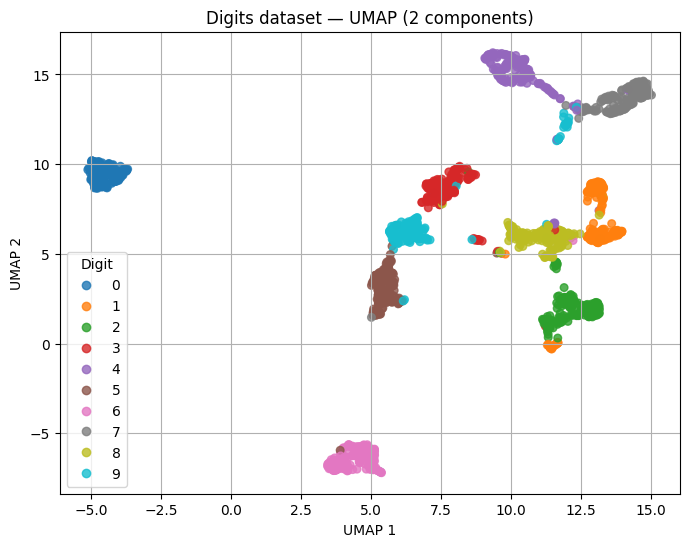

In [9]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_umap2[:,0], X_umap2[:,1], c=y, cmap='tab10', s=30, alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Digit")
plt.title('Digits dataset — UMAP (2 components)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


## 6) Benchmark: Classifier performance before vs. after dimensionality reduction

We'll train a Logistic Regression and Random Forest classifier on:
- Original (scaled) features
- PCA-reduced features (using enough components to explain ~95% variance)
- UMAP or t-SNE embeddings (note: t-SNE is typically for visualization — using it as features for classifiers is uncommon but shown here for experiment)


In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# 1) Original features (scaled) with Logistic Regression
clf_lr = LogisticRegression(max_iter=2000, random_state=42)
clf_lr.fit(X_train, y_train)
pred_lr = clf_lr.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)
print("Logistic Regression on original features — accuracy:", acc_lr)

# 2) PCA to 95% variance
pca95 = PCA(n_components=0.95, random_state=42)  # choose components to explain 95% variance
X_pca95 = pca95.fit_transform(X_scaled)
Xtr_pca95, Xte_pca95, ytr_pca95, yte_pca95 = train_test_split(X_pca95, y, test_size=0.25, random_state=42, stratify=y)
clf_lr_pca = LogisticRegression(max_iter=2000, random_state=42)
clf_lr_pca.fit(Xtr_pca95, ytr_pca95)
pred_pca = clf_lr_pca.predict(Xte_pca95)
acc_pca = accuracy_score(yte_pca95, pred_pca)
print("Logistic Regression on PCA(95%) features — accuracy:", acc_pca)

# 3) Random Forest on original features
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)
print("Random Forest on original features — accuracy:", acc_rf)

# 4) Quick experiment: use UMAP embedding as features (fit on full scaled data then split)
from sklearn.model_selection import train_test_split
X_umap_full = reducer.fit_transform(X_scaled)
Xtr_u, Xte_u, ytr_u, yte_u = train_test_split(X_umap_full, y, test_size=0.25, random_state=42, stratify=y)
clf_lr_umap = LogisticRegression(max_iter=2000, random_state=42)
clf_lr_umap.fit(Xtr_u, ytr_u)
pred_umap = clf_lr_umap.predict(Xte_u)
acc_umap = accuracy_score(yte_u, pred_umap)
print("Logistic Regression on UMAP features (2D) — accuracy:", acc_umap)

# Summary table
results = pd.DataFrame({
    'method': ['LR original', 'LR PCA(95%)', 'RF original', 'LR UMAP(2D)'],
    'accuracy': [acc_lr, acc_pca, acc_rf, acc_umap]
})
results


Logistic Regression on original features — accuracy: 0.9777777777777777
Logistic Regression on PCA(95%) features — accuracy: 0.96
Random Forest on original features — accuracy: 0.9666666666666667
Logistic Regression on UMAP features (2D) — accuracy: 0.9066666666666666


,method,accuracy
0,LR original,0.977778
1,LR PCA(95%),0.960000
2,RF original,0.966667
3,LR UMAP(2D),0.906667


## 7) Summary & Insights

- **PCA** — fast, linear; great for reducing dimensionality while preserving variance. Use for preprocessing and speeding up downstream tasks.
- **t-SNE** — excellent for visualizing local clusters; computationally heavier and non-linear. Not ideal as input features for supervised learning.
- **UMAP** — often matches or exceeds t-SNE for quality while being faster and more scalable; useful both for visualization and as a preprocessing step.
